In [35]:
import random
import sys

try:
    sys.path.remove('/Users/vblot/Documents/projects/mapie/original/MAPIE')
    sys.path.remove('/Users/vblot/Documents/projects/mapie/original/MAPIE')
except:
    pass
sys.path.append("/Users/vblot/Documents/projects/cemracs/conformalized_gp/")
# sys.path.append("/Users/vblot/Documents/projects/cemracs/conformal_uq")

import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
from scipy.stats import bootstrap

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import mmd
from mapie.conformity_scores.residual_conformity_scores import GPCrossConformityScore
from mapie.metrics import regression_coverage_score_v2, regression_mean_width_score
from mapie.regression import MapieRegressor
from notebooks_gp.adaptivity_measures import hsic_ot, my_correlation_pearson, q2, recap_permutation_test, tree_mse, my_correlation_spearman
from notebooks_gp.datasets import get_morokoff
from notebooks_gp.plot_functions import get_max_variable, plot_distribution, plot_prediction_intervals, plot_width_error
from wrappers import GpOTtoSklearnStd


plt.rcParams["figure.dpi"] = 100
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get data

In [2]:
DATA_PATH = "/Users/vblot/Documents/projects/cemracs/data_UQ"
EDF_BLUE = np.array([[26, 54, 105]]) / 255
CAP_BLUE = np.array([[48, 112, 170]]) / 255
PS_VIOLET = np.array([[84, 13, 46]]) / 255
EDF_ORANGE = np.array([[223, 84, 49]]) / 255
LISN_YELLOW = np.array([[242, 188, 64]]) / 255
METHOD = "plus"
N_POINTS_TRAIN = "all"
CV = 10
SAVE_PLOT = False


In [3]:
X, y = get_morokoff(noisy=True, nobs=200)

In [4]:
print(X.shape, y.shape)

(200, 10) (200,)


# Split into train test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
n_train = N_POINTS_TRAIN
n_train = len(X_train) if type(n_train) == str else n_train
random.seed(42)
indexes_train = np.random.choice(range(len(X_train)), n_train, replace=False)
X_train = X_train[indexes_train]
y_train = y_train[indexes_train]

In [6]:
print(
    f"  N training points = {len(X_train)}\n",
    f" N testing points = {len(X_test)}"
)

  N training points = 160
  N testing points = 40


# Get data

In [7]:
scaler = StandardScaler().fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

# Fit GP

In [10]:
nu = 5/2
noise = None

In [11]:
models = {
    "J+GP": {
        "estimator": GpOTtoSklearnStd(scale=1, amplitude=1.0, nu=nu, noise=noise),
        "color": LISN_YELLOW
    },
    "J-minmax-GP": {
        "estimator": GpOTtoSklearnStd(scale=1, amplitude=1.0, nu=nu, noise=noise),
        "color": EDF_ORANGE
    },
     "GP": {
        "estimator": GpOTtoSklearnStd(scale=1, amplitude=1.0, nu=nu, noise=noise),
        "color": "black"
    }
}

In [12]:
for model_name, model in models.items():
    print("Fitting ", model_name)
    model["estimator"].fit(X_train_scale, y_train)


Fitting  CV+GP
Fitting  CV-minmax-GP
Fitting  CV+
Fitting  CV-minmax
Fitting  GP


WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.81422,6.67021,6.73579,6.78326,7.57666,6.78734,6.92692,6.5869]#10


In [13]:
for model_name, model in models.items():
    print(model_name, "MSE:", mean_squared_error(y_test, model["estimator"].predict(X_test_scale)))

CV+GP MSE: 0.0027202686055065014
CV-minmax-GP MSE: 0.0027202686055065014
CV+ MSE: 0.0027202686055065014
CV-minmax MSE: 0.0027202686055065014
GP MSE: 0.0027202686055065014


In [14]:
for model_name, model in models.items():
    print(model_name, "Q2:", q2(y_test, model["estimator"].predict(X_test_scale)))

CV+GP Q2: 0.8346721833808947
CV-minmax-GP Q2: 0.8346721833808947
CV+ Q2: 0.8346721833808947
CV-minmax Q2: 0.8346721833808947
GP Q2: 0.8346721833808947


# Fit MAPIE

In [15]:
for model_name, model in models.items():
    if model_name != "GP":
        if "+" in model_name:
            METHOD = "plus"
        else:
            METHOD = "minmax"
        models[model_name]["mapie_estimator"] = MapieRegressor(
            estimator=model["estimator"],
            conformity_score=GPCrossConformityScore(sym=True) if "GP" in model_name else None,
            cv=CV,
            method=METHOD,
            model_has_std=True if "GP" in model_name else False,
            random_state=42
        )


In [16]:
for model_name, model in models.items():
    print("Fitting MAPIE", model_name)
    model["mapie_estimator"].fit(X_train_scale, y_train)


Fitting MAPIE CV+GP


WRN - (previous message repeated 7 times)
WRN - Warning! TNC algorithm failed. The error message is Linear search failed
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.81422,6.67021,6.6169,6.78326,7.57666,6.78734,6.84665,6.48673]#10
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.77364,6.66584,6.73579,6.78326,7.57666,6.77061,6.92692,6.5869]#10
WRN - Warning! For coherency we set scale upper bounds = [7.00126,6.95358,6.81422,6.59889,6.73579,6.78326,7.54532,6.71692,6.92692,6.5869]#10
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.81422,6.67021,6.73579,6.70357,7.57666,6.78734,6.8971,6.5869]#10
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.81422,6.67021,6.73579,6.78326,7.45123,6.78734,6.92692,6.5869]#10
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.81422,6.67021,6.73579,6.78326,7.57666,6.78734,6.92692,6.5869]#10
WRN - Warning! For coherency we se

Fitting MAPIE CV-minmax-GP


WRN - (previous message repeated 3 times)
WRN - Warning! TNC algorithm failed. The error message is Linear search failed
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.81422,6.67021,6.6169,6.78326,7.57666,6.78734,6.84665,6.48673]#10
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.77364,6.66584,6.73579,6.78326,7.57666,6.77061,6.92692,6.5869]#10
WRN - Warning! For coherency we set scale upper bounds = [7.00126,6.95358,6.81422,6.59889,6.73579,6.78326,7.54532,6.71692,6.92692,6.5869]#10
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.81422,6.67021,6.73579,6.70357,7.57666,6.78734,6.8971,6.5869]#10
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.81422,6.67021,6.73579,6.78326,7.45123,6.78734,6.92692,6.5869]#10
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.81422,6.67021,6.73579,6.78326,7.57666,6.78734,6.92692,6.5869]#10
WRN - Warning! For coherency we se

Fitting MAPIE CV+


WRN - (previous message repeated 3 times)
WRN - Warning! TNC algorithm failed. The error message is Linear search failed
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.81422,6.67021,6.6169,6.78326,7.57666,6.78734,6.84665,6.48673]#10
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.77364,6.66584,6.73579,6.78326,7.57666,6.77061,6.92692,6.5869]#10
WRN - Warning! For coherency we set scale upper bounds = [7.00126,6.95358,6.81422,6.59889,6.73579,6.78326,7.54532,6.71692,6.92692,6.5869]#10
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.81422,6.67021,6.73579,6.70357,7.57666,6.78734,6.8971,6.5869]#10
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.81422,6.67021,6.73579,6.78326,7.45123,6.78734,6.92692,6.5869]#10
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.81422,6.67021,6.73579,6.78326,7.57666,6.78734,6.92692,6.5869]#10
WRN - Warning! For coherency we se

Fitting MAPIE CV-minmax


WRN - (previous message repeated 3 times)
WRN - Warning! TNC algorithm failed. The error message is Linear search failed
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.81422,6.67021,6.6169,6.78326,7.57666,6.78734,6.84665,6.48673]#10
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.77364,6.66584,6.73579,6.78326,7.57666,6.77061,6.92692,6.5869]#10
WRN - Warning! For coherency we set scale upper bounds = [7.00126,6.95358,6.81422,6.59889,6.73579,6.78326,7.54532,6.71692,6.92692,6.5869]#10
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.81422,6.67021,6.73579,6.70357,7.57666,6.78734,6.8971,6.5869]#10
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.81422,6.67021,6.73579,6.78326,7.45123,6.78734,6.92692,6.5869]#10
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.81422,6.67021,6.73579,6.78326,7.57666,6.78734,6.92692,6.5869]#10
WRN - Warning! For coherency we se

Fitting MAPIE GP


WRN - (previous message repeated 3 times)
WRN - Warning! TNC algorithm failed. The error message is Linear search failed
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.81422,6.67021,6.6169,6.78326,7.57666,6.78734,6.84665,6.48673]#10
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.77364,6.66584,6.73579,6.78326,7.57666,6.77061,6.92692,6.5869]#10
WRN - Warning! For coherency we set scale upper bounds = [7.00126,6.95358,6.81422,6.59889,6.73579,6.78326,7.54532,6.71692,6.92692,6.5869]#10
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.81422,6.67021,6.73579,6.70357,7.57666,6.78734,6.8971,6.5869]#10
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.81422,6.67021,6.73579,6.78326,7.45123,6.78734,6.92692,6.5869]#10
WRN - Warning! For coherency we set scale upper bounds = [7.04392,6.99565,6.81422,6.67021,6.73579,6.78326,7.57666,6.78734,6.92692,6.5869]#10
WRN - Warning! For coherency we se

# Coverage

In [17]:
ALPHA = np.arange(0.01, .99, 0.01)
q_alpha_min = scipy.stats.norm.ppf(ALPHA / 2)
q_alpha_max = scipy.stats.norm.ppf(1 - ALPHA / 2)
y_mean, y_std = models["GP"]["estimator"].predict(X_test_scale, return_std=True)
y_pss_gp = np.concatenate(
    [
        (y_mean.reshape(-1, 1) + y_std.reshape(-1, 1) * q_alpha_min.reshape(1, -1))[:, np.newaxis, :],
        (y_mean.reshape(-1, 1) + y_std.reshape(-1, 1) * q_alpha_max.reshape(1, -1))[:, np.newaxis, :]
    ],
    axis=1
)
models["GP"]["y_pss"] = y_pss_gp

In [18]:
models.keys()

dict_keys(['CV+GP', 'CV-minmax-GP', 'CV+', 'CV-minmax', 'GP'])

In [19]:
for model_name, model in models.items():
    if model_name != "GP":
        print("Predict MAPIE", model_name)
        _, y_pss = model["mapie_estimator"].predict(X_test_scale, alpha=ALPHA)
        model["y_pss"] = y_pss


Predict MAPIE CV+GP
Predict MAPIE CV-minmax-GP
Predict MAPIE CV+
Predict MAPIE CV-minmax


In [20]:
for model_name, model in models.items():
    model["coverage"] = [
        regression_coverage_score_v2(y_test, model["y_pss"][:, :, i])
        for i, _ in enumerate(ALPHA)
    ]
    model["average_width"] = [
        regression_mean_width_score(
            model["y_pss"][:, 1, i], model["y_pss"][:, 0, i]
        )
        for i, _ in enumerate(ALPHA)
    ]
    model["median_width"] = [
        np.median(np.abs(
             model["y_pss"][:, 1, i] -  model["y_pss"][:, 0, i]
        ))
        for i, _ in enumerate(ALPHA)
    ]
    model["var_width"] = [
        np.std(np.abs(
             model["y_pss"][:, 1, i] -  model["y_pss"][:, 0, i]
        ))
        for i, _ in enumerate(ALPHA)
    ]


CV+GP
CV-minmax-GP
CV+
CV-minmax
GP


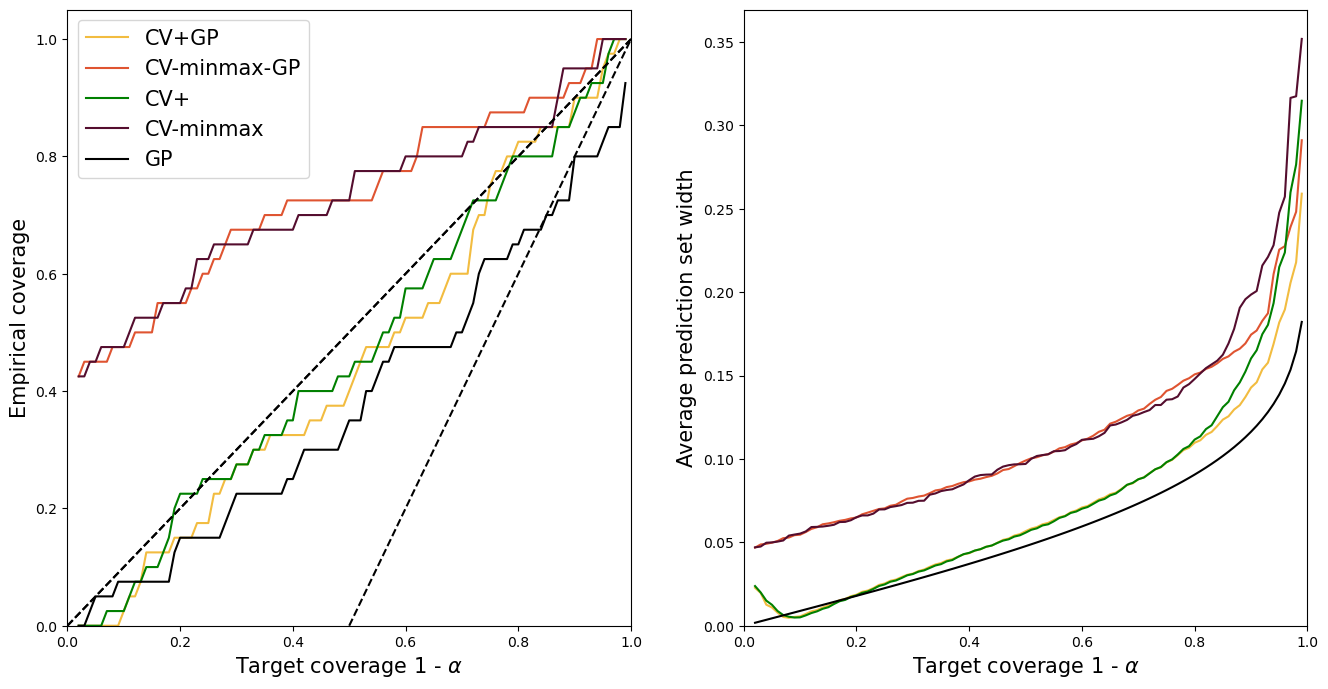

In [21]:
fs = 15
ncols = 2
nrows = 1
s = 8
f, ax = plt.subplots(nrows, ncols, figsize=(ncols * s, nrows * s), squeeze=False)

for model_name, model in models.items():
    print(model_name)
    cov = model["coverage"]
    ax[0, 0].plot(1 - ALPHA, cov, label=model_name, c=model["color"])
ax[0, 0].plot([[0, 0], [1, 1]], linestyle='dashed', c='black')
ax[0, 0].plot([0.5, 1], [0, 1], linestyle='dashed', c='black')
ax[0, 0].set_ylabel("Empirical coverage", fontsize=fs)


for model_name, model in models.items():
    width = model["average_width"]
    ax[0, 1].plot(1 - ALPHA, width, label=model_name, c=model["color"])
ax[0, 1].set_ylabel("Average prediction set width", fontsize=fs)

for i in (0, 1):
        ax[0, i].set_xlabel(r"Target coverage 1 - $\alpha$", fontsize=fs)
        ax[0, i].set_xlim(0, 1)
        ax[0, i].set_ylim(0)

ax[0, 0].legend(fontsize=15, loc="upper left")


# Set desired confidence level


In [22]:
CONFIDENCE = .9
index_confidence = np.argmax(np.isclose(ALPHA, 1 - CONFIDENCE))

# Correlation between width of the Prediction Interval and the error of the model


In [26]:
for model_name, model in models.items():
    if model_name != "GP":
        model["errors"] = np.abs(model["mapie_estimator"].predict(X_test_scale, alpha=None) - y_test)
        model["width"] = np.abs(model["y_pss"][:, 0, index_confidence] - model["y_pss"][:, 1, index_confidence])
    else:
        model["errors"] = np.abs(model["estimator"].predict(X_test_scale) - y_test)
        model["width"] = np.abs(model["y_pss"][:, 0, index_confidence] - model["y_pss"][:, 1, index_confidence])


In [27]:

for model_name, model in models.items():
    str_vect = [e + '--' + w for e, w in zip(model["errors"].astype("str").tolist(), model["width"].astype("str").tolist())]
    model["pearson_correlation_to_error"] = bootstrap(
        (np.array(str_vect), ),
        my_correlation_pearson,
        axis=0
    )
    model["spearman_correlation_to_error"] = bootstrap(
        (np.array(str_vect), ),
        my_correlation_spearman,
        axis=0
    )
    model["hsic_to_error"] = hsic_ot(
        scipy.stats.rankdata(model["errors"]),
        scipy.stats.rankdata(model["width"])
    )


# Fit model to predict error with size of PS


In [28]:
for model_name, model in models.items():
    
    width = np.abs(model["y_pss"][:, 0, index_confidence] - model["y_pss"][:, 1, index_confidence])
    str_vect = [e + '--' + w for e, w in zip( width.astype("str").tolist(), model["errors"].astype("str").tolist())]
    model["tree_mse"] = bootstrap(
        (np.array(str_vect), ),
        tree_mse,
        axis=0
    )


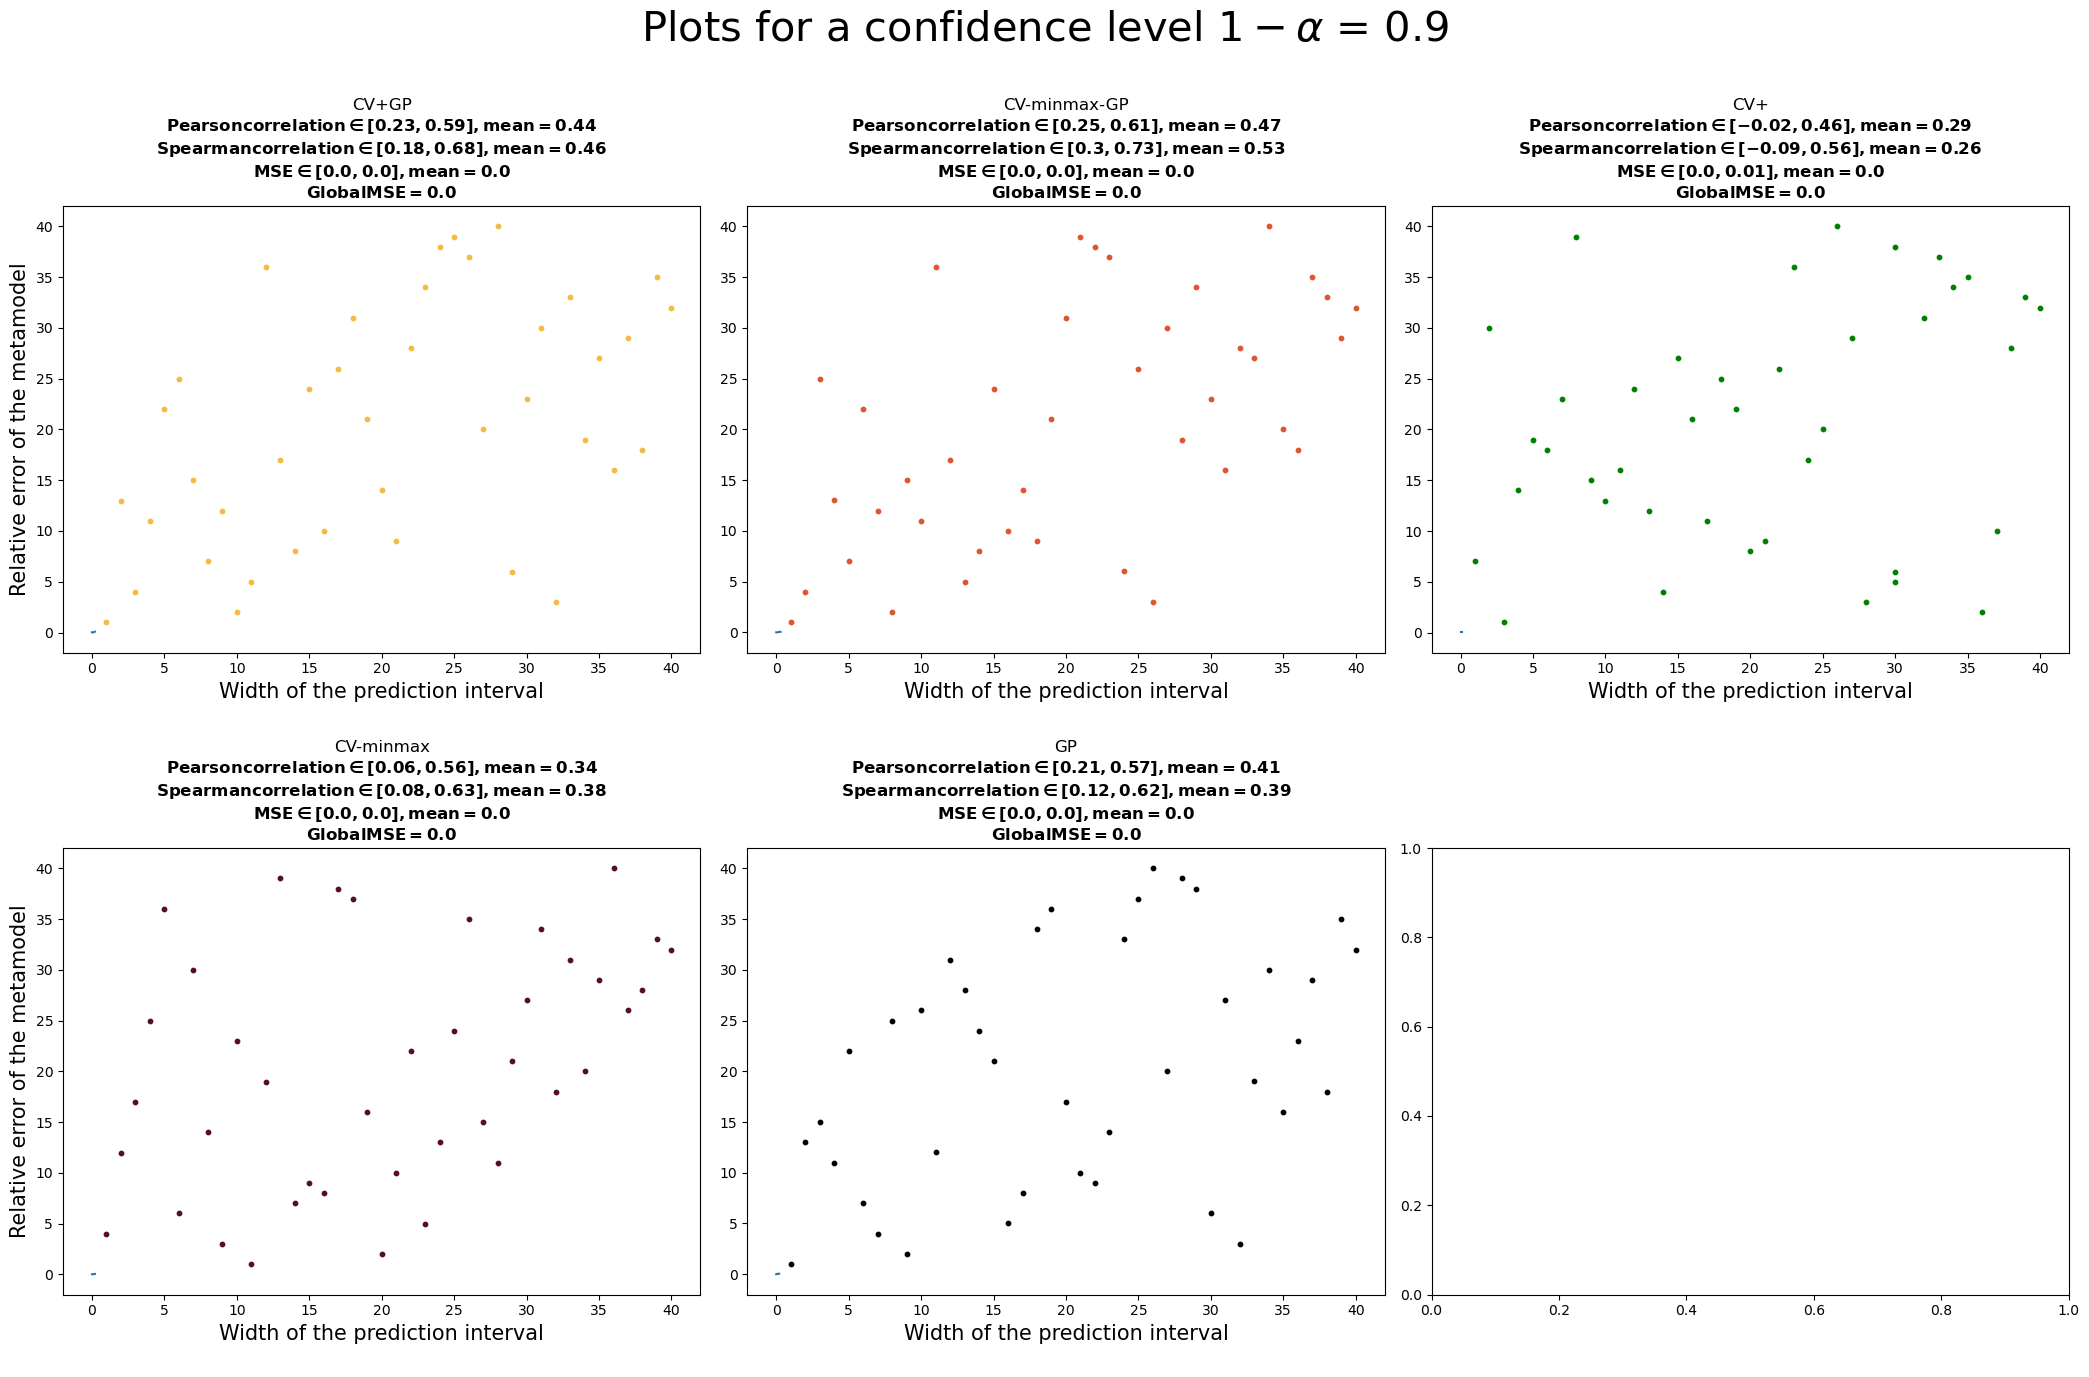

In [29]:
ncols = 3
nrows = len(models) // ncols + (len(models) % ncols != 0)
s = 7
f, ax = plt.subplots(nrows, ncols, figsize=(ncols * s, nrows * s), squeeze=False)

for i, (model_name, model) in enumerate(models.items()):
    r, c = i // ncols, i % ncols
    
    plot_width_error(model, model_name, ax, r, c, plot_rank=True)
f.suptitle(r"Plots for a confidence level $1 - \alpha$ = " + str(round(1 - ALPHA[index_confidence], 2)) + "\n", fontsize=30)

plt.tight_layout()

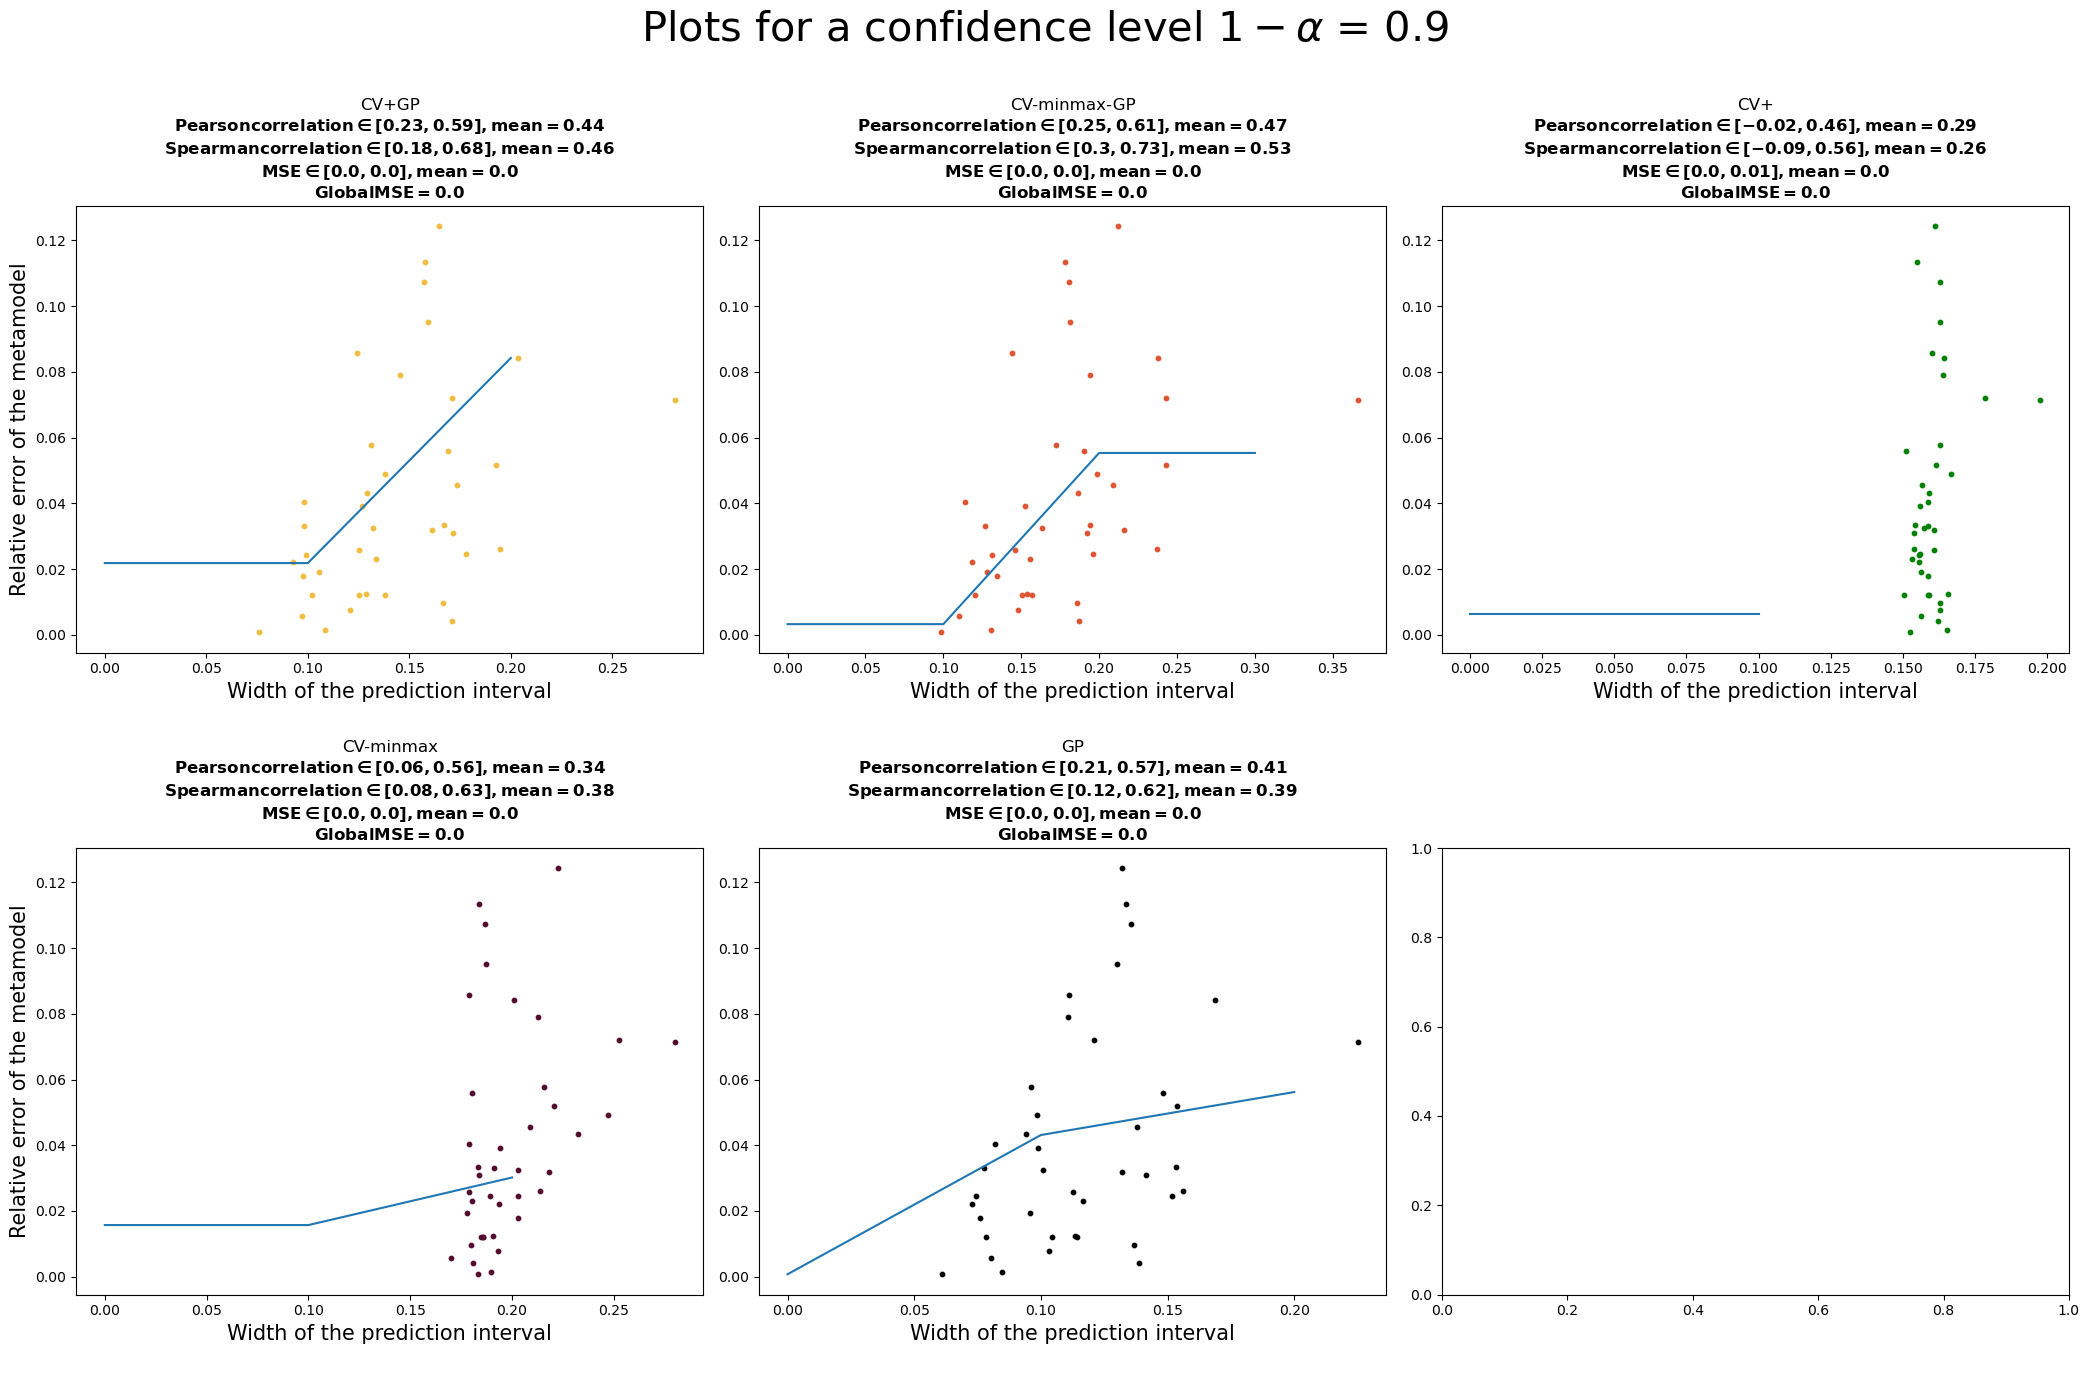

In [30]:
ncols = 3
nrows = len(models) // ncols + (len(models) % ncols != 0)
s = 7
f, ax = plt.subplots(nrows, ncols, figsize=(ncols * s, nrows * s), squeeze=False)

for i, (model_name, model) in enumerate(models.items()):
    r, c = i // ncols, i % ncols
    
    plot_width_error(model, model_name, ax, r, c, plot_rank=False)
f.suptitle(r"Plots for a confidence level $1 - \alpha$ = " + str(round(1 - ALPHA[index_confidence], 2)) + "\n", fontsize=30)

plt.tight_layout()

## Plot correlations distributions


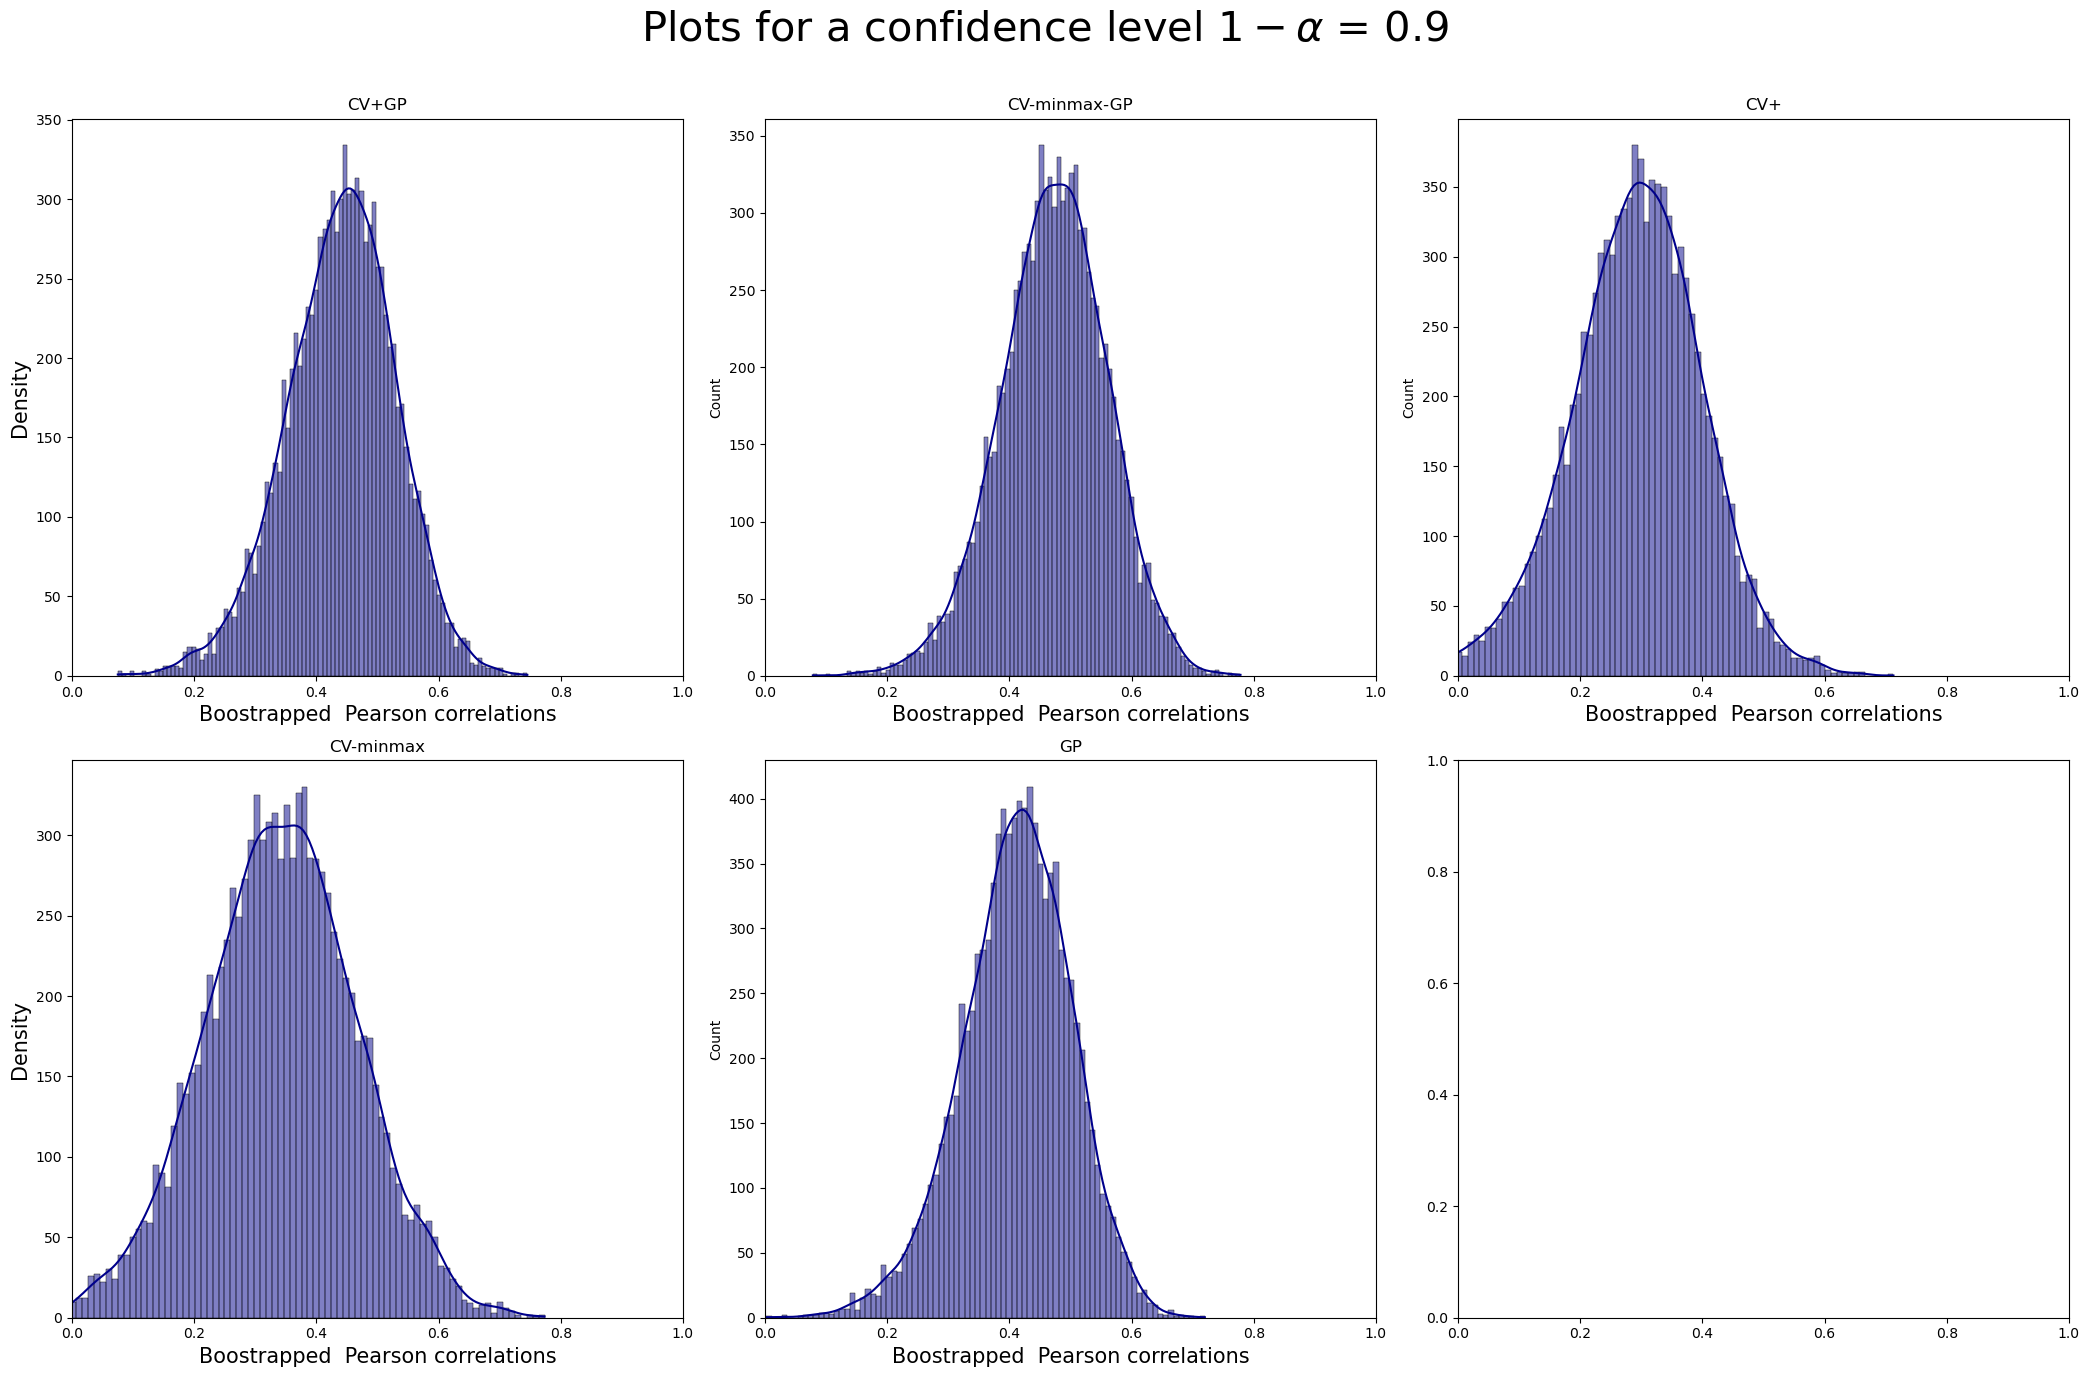

In [32]:
ncols = 3
nrows = len(models) // ncols + (len(models) % ncols != 0)
s = 7
f, ax = plt.subplots(nrows, ncols, figsize=(ncols * s, nrows * s), squeeze=False)

for i, (model_name, model) in enumerate(models.items()):
    r, c = i // ncols, i % ncols
    distribution = model["pearson_correlation_to_error"].bootstrap_distribution
    plot_distribution(
        distribution, model_name, "Boostrapped  Pearson correlations", ax[r, c]
    )
    ax[r, 0].set_ylabel("Density", size=15)

f.suptitle(r"Plots for a confidence level $1 - \alpha$ = " + str(round(1 - ALPHA[index_confidence], 2)) + "\n", fontsize=30)

plt.tight_layout()


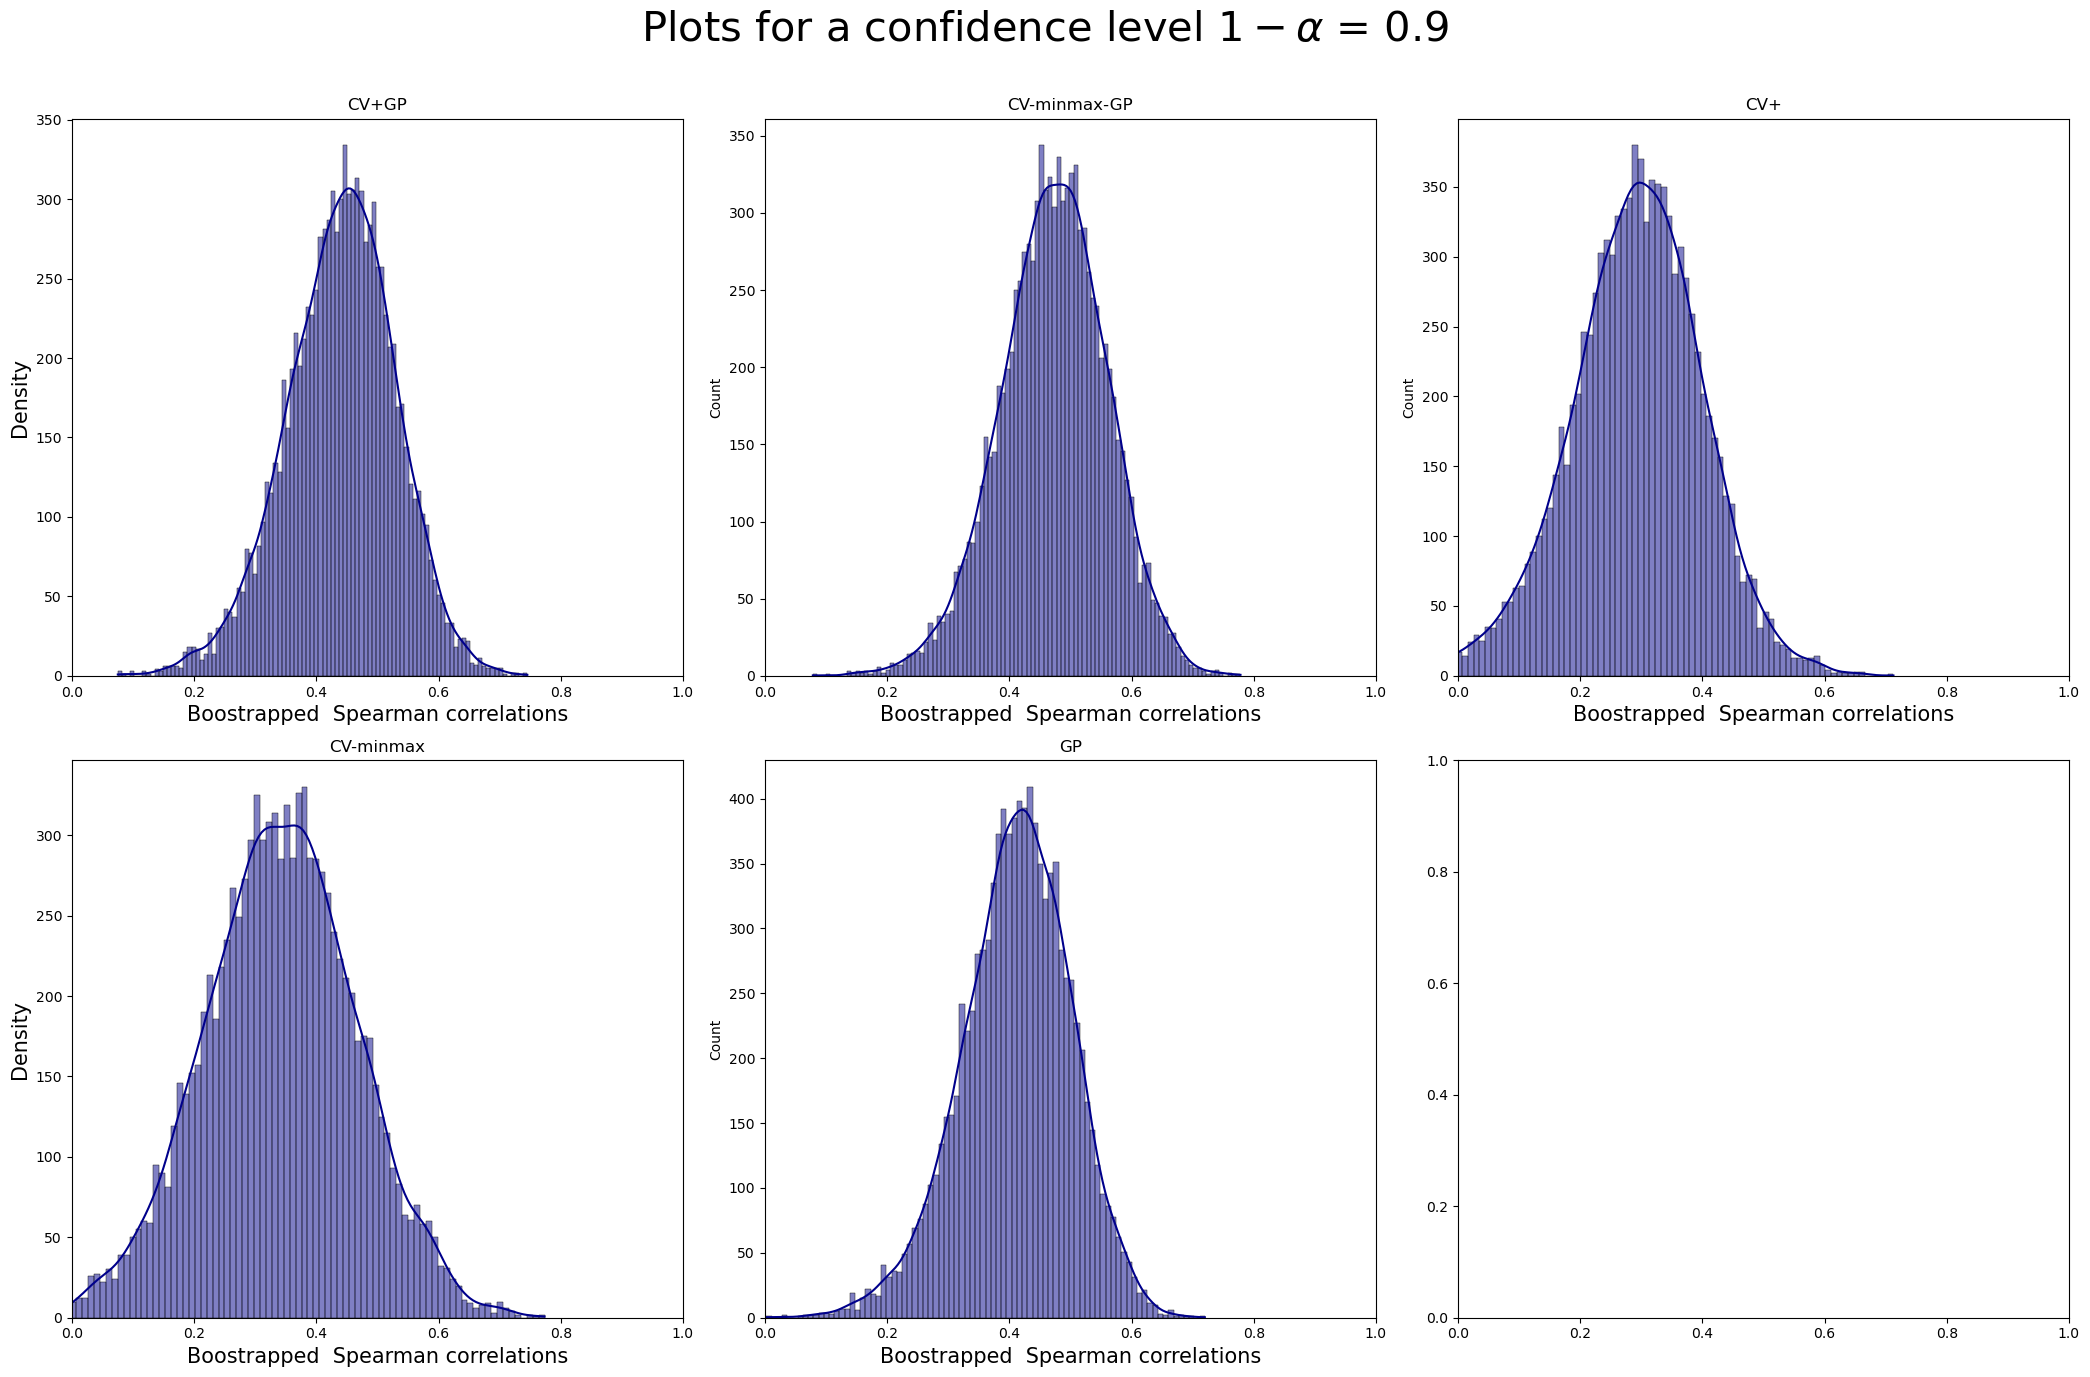

In [33]:
ncols = 3
nrows = len(models) // ncols + (len(models) % ncols != 0)
s = 7
f, ax = plt.subplots(nrows, ncols, figsize=(ncols * s, nrows * s), squeeze=False)

for i, (model_name, model) in enumerate(models.items()):
    r, c = i // ncols, i % ncols
    distribution = model["pearson_correlation_to_error"].bootstrap_distribution
    plot_distribution(
        distribution, model_name, "Boostrapped  Spearman correlations", ax[r, c]
    )
    ax[r, 0].set_ylabel("Density", size=15)

f.suptitle(r"Plots for a confidence level $1 - \alpha$ = " + str(round(1 - ALPHA[index_confidence], 2)) + "\n", fontsize=30)

plt.tight_layout()


# Plot MSE distributions


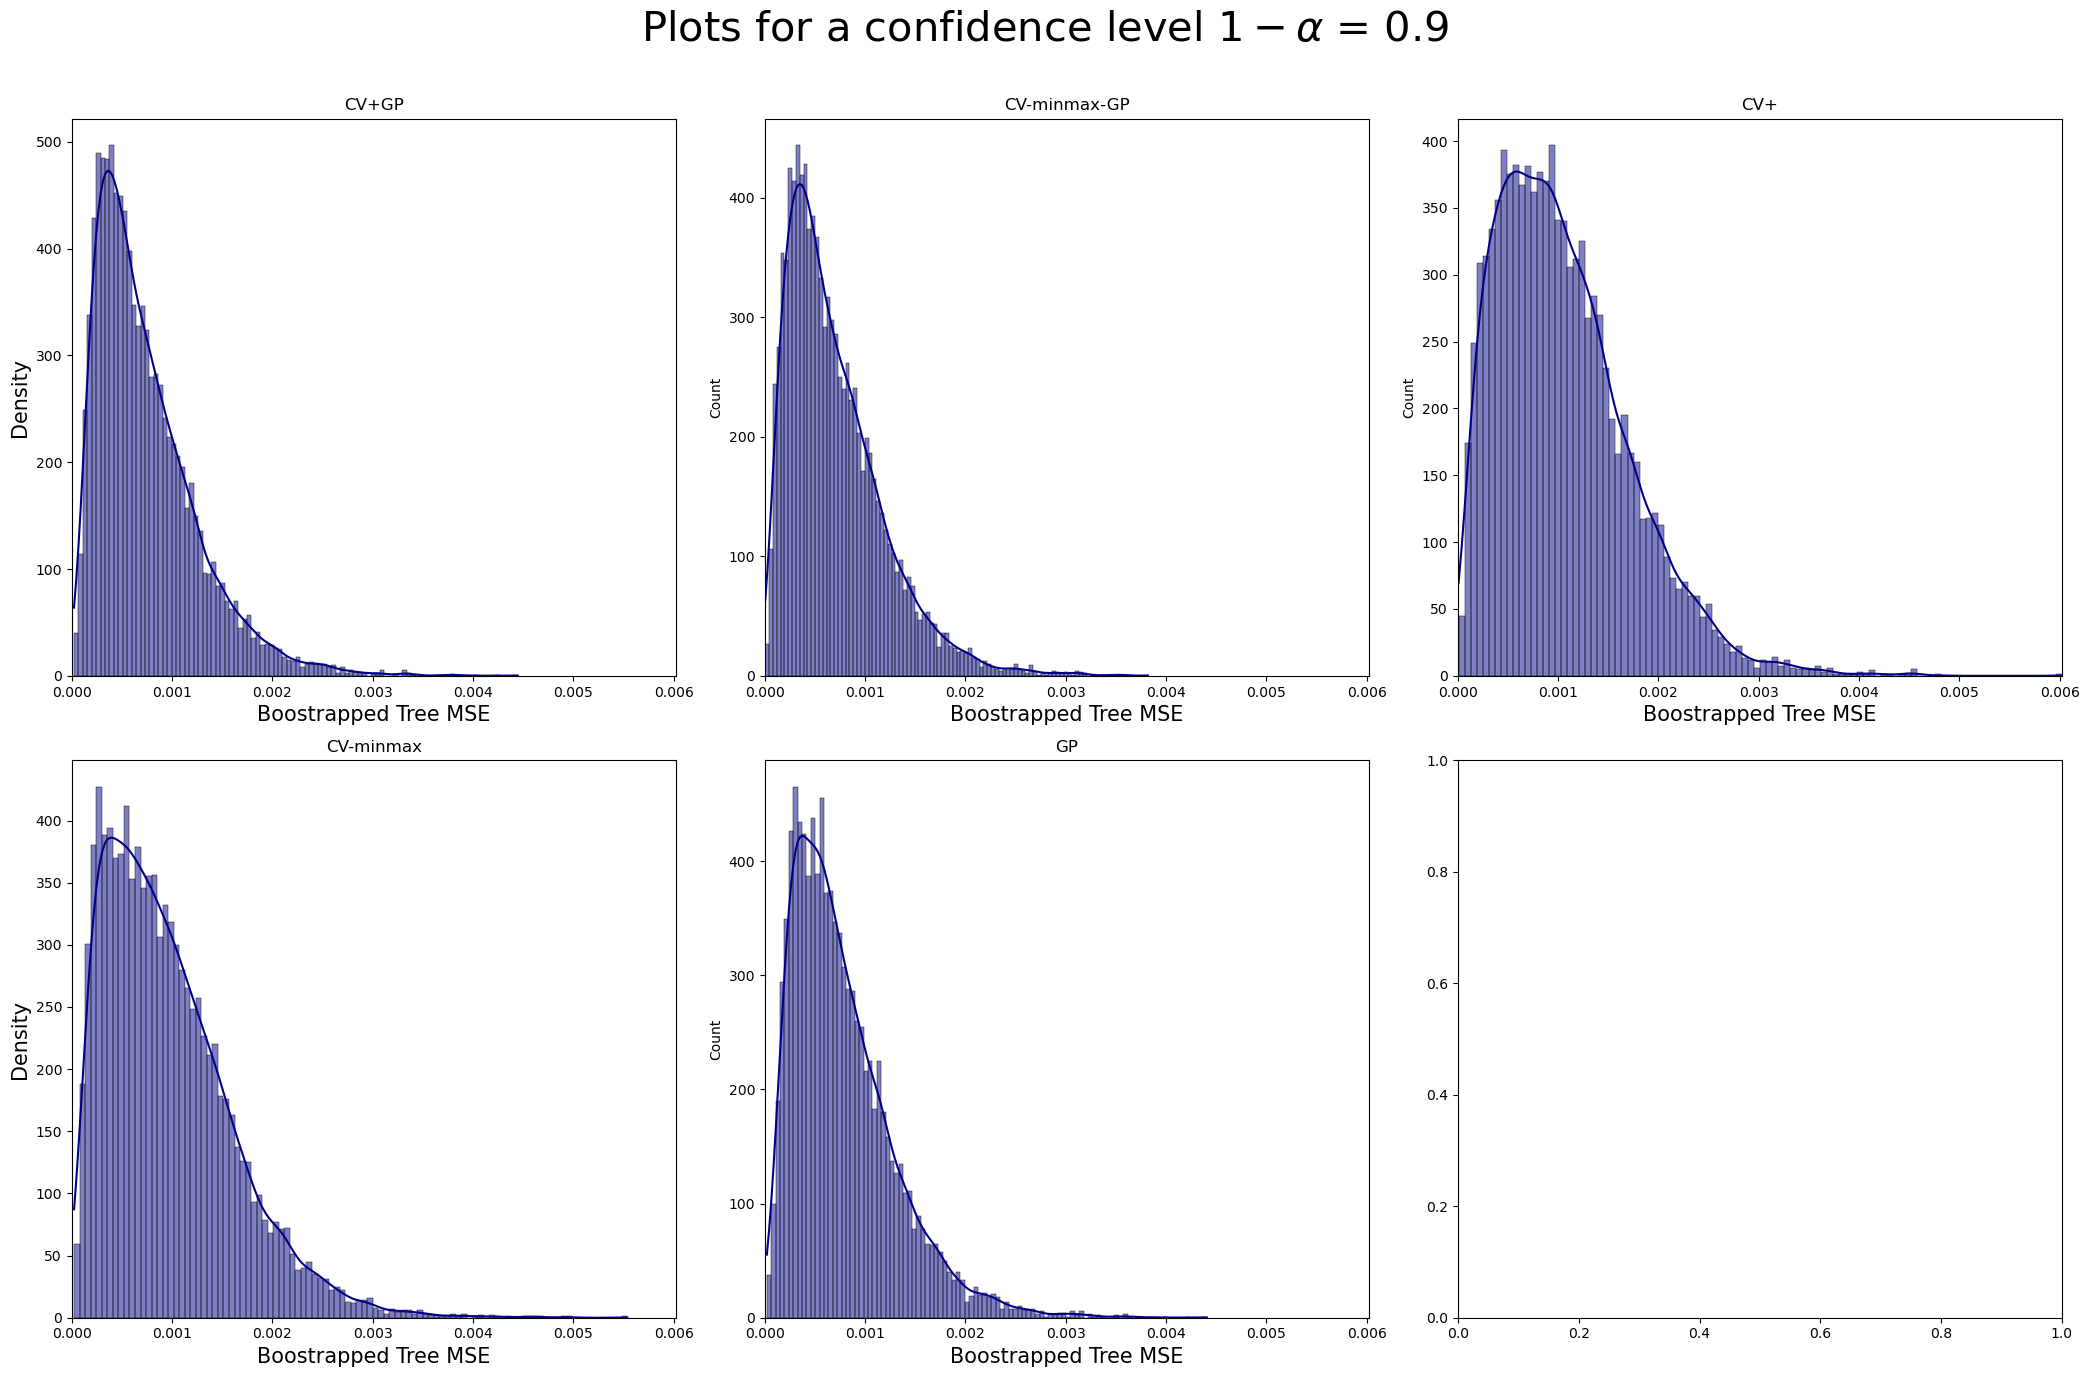

In [57]:
ncols = 3
nrows = len(models) // ncols + (len(models) % ncols != 0)
s = 7
f, ax = plt.subplots(nrows, ncols, figsize=(ncols * s, nrows * s), squeeze=False)

max_mse = get_max_variable(models, "tree_mse", index_confidence=None)
for i, (model_name, model) in enumerate(models.items()):
    r, c = i // ncols, i % ncols
    distribution = model["tree_mse"].bootstrap_distribution
    plot_distribution(
        distribution, model_name, "Boostrapped Tree MSE", ax[r, c],
        xmax=max_mse
    )
    ax[r, 0].set_ylabel("Density", size=15)
f.suptitle(r"Plots for a confidence level $1 - \alpha$ = " + str(round(1 - ALPHA[index_confidence], 2)) + "\n", fontsize=30)

plt.tight_layout()



# Size of the Prediction Intervals

In [58]:
# Get average width of the prediction intervals for each model in a pandas DataFrame

df_width = pd.DataFrame(
    {
        model_name: model["average_width"]
        for model_name, model in models.items()
    },
    index=1 - ALPHA
)
df_width.loc[1 - ALPHA[index_confidence], :]

CV+GP           0.142835
CV-minmax-GP    0.174564
CV+             0.160284
CV-minmax       0.198603
GP              0.116344
Name: 0.9, dtype: float64

In [59]:
# Get average std of the prediction intervals for each model in a pandas DataFrame

df_std = pd.DataFrame(
    {
        model_name: model["var_width"]
        for model_name, model in models.items()
    },
    index=1 - ALPHA
)
df_std.loc[1 - ALPHA[index_confidence], :]

CV+GP           0.038591
CV-minmax-GP    0.048854
CV+             0.007884
CV-minmax       0.022967
GP              0.032375
Name: 0.9, dtype: float64

## Permutation test to test that the correlation is higher with CP  than without


In [61]:
recap_permutation_test(models, "pearson_correlation_to_error", alternative="less")



,test statistic,p-value
gp_vs_gp_plus,-0.028903,0.0001
gp_vs_cv_plus,0.121210,1.0000
cv_plus_vs_gp_plus,-0.150113,0.0001
gp_vs_gp_minmax,-0.061218,0.0001
gp_plus_vs_gp_minmax,-0.032315,0.0001


## Permutation test to test that the MSE lower with CP than without


In [62]:
recap_permutation_test(models, "tree_mse", alternative="greater")


,test statistic,p-value
gp_vs_gp_plus,0.000038,0.0001
gp_vs_cv_plus,-0.000271,1.0000
cv_plus_vs_gp_plus,0.000309,0.0001
gp_vs_gp_minmax,0.000080,0.0001
gp_plus_vs_gp_minmax,0.000042,0.0001


# HSIC between length of the PI and the indicator of coverage 


In [63]:
for model_name, model in models.items():
    y_above_inf = y_test >= model["y_pss"][:, 0, index_confidence]
    y_bellow_sup = y_test <= model["y_pss"][:, 1, index_confidence]

    model["y_true_in_interval"] = y_above_inf * y_bellow_sup
    


In [64]:
dict_hsic = {}

for model_name, model in models.items():
    hsic_result = hsic_ot(
        np.abs(
            model["y_pss"][:, 0, index_confidence] - model["y_pss"][:, 1, index_confidence]
        ),
        model["y_true_in_interval"]
    )
    dict_hsic[model_name] = {
        "HSIC-stat": hsic_result[0],
        "p-value": hsic_result[1]
    }
pd.DataFrame(dict_hsic).T


,HSIC-stat,p-value
CV+GP,0.043419,0.340437
CV-minmax-GP,0.021483,0.934314
CV+,0.035068,0.496222
CV-minmax,0.027674,0.789289
GP,0.088412,0.036095


# MMD


In [65]:
for model_name, model in models.items():
    width = np.array(model["average_width"])[:, np.newaxis]
    error = model["errors"][:, np.newaxis]
    model["mmd_linear"] = mmd.mmd_linear(width, error)
    model["mmd_rbf"] = mmd.mmd_rbf(width, error)
    model["mmd_poly"] = mmd.mmd_poly(width, error)
pd.DataFrame(models).loc[["mmd_linear", "mmd_rbf", "mmd_poly"]]

,CV+GP,CV-minmax-GP,CV+,CV-minmax,GP
mmd_linear,0.000771,0.004814,0.001012,0.00537,0.00024
mmd_rbf,0.001518,0.009482,0.001973,0.010484,0.000475
mmd_poly,0.000023,0.000142,0.000042,0.000197,0.000005
